In [30]:
#import pairs_backtest as pb
import talib 
import numpy as np
import datetime as dt #in-built module
import pandas as pd
from pandas_datareader import data
import yfinance as yf
from yahoo_fin import stock_info as si
import matplotlib.pyplot as plt
from matplotlib import style
from pathlib import Path
import os
from tqdm import tqdm   
from pairs_backtest import kalman_lib as kalman
from pairs_backtest import find_pairs
from pairs_backtest import utils
from pandas_datareader import data as pdr
import statsmodels.tsa.stattools as ts 
import seaborn as sns
import statsmodels.api as sm

In [2]:
import pandas as pd

# pretty printing of pandas dataframe
pd.set_option('expand_frame_repr', False)
pd.set_option("display.max_rows", None, "display.max_columns", None)


# There are 4 tables on the Wikipedia page
# we want the last table

payload=pd.read_html('https://en.wikipedia.org/wiki/Nasdaq-100')
fourth_table = payload[4]

df = fourth_table

In [3]:
date = dt.datetime.now()
today = '%s_%s_%s'%(date.year,date.month,date.day)

start = dt.datetime.now()- dt.timedelta(days=730)
end = dt.datetime.now()
df = pdr.get_data_yahoo(df['Ticker'].values.tolist(), start, end)['Adj Close']


[*********************100%***********************]  101 of 101 completed


In [ ]:

#print('All_US_STOCK_NAS',df)
score_matrix, pvalue_matrix, pairs = find_pairs.find_cointegrated_pairs(df)
print (pairs)
#find_pairs.save_txt(pairs)  #save all the pairs
df_pairs = pd.DataFrame(pairs, columns = ['s1','s2','p-value'])
df_pairs = df_pairs.sort_values(by=['p-value']).head(1000)
df_pairs.to_csv("pairs_%s_NAS.csv"%today)

Run


In [31]:
def get_data(code,start,end):
    data = yf.Ticker(code)
    data = data.history(start = start, end = end)
    #data.index = data.index.strftime('%d/%m/%Y')
    return data

In [32]:
pairs = pd.read_csv('pairs_2024_2_28_NAS.csv')


In [33]:
combin_df_index = get_data('SPY',start,end).index
combin_df_index

DatetimeIndex(['2022-03-24 00:00:00-04:00', '2022-03-25 00:00:00-04:00',
               '2022-03-28 00:00:00-04:00', '2022-03-29 00:00:00-04:00',
               '2022-03-30 00:00:00-04:00', '2022-03-31 00:00:00-04:00',
               '2022-04-01 00:00:00-04:00', '2022-04-04 00:00:00-04:00',
               '2022-04-05 00:00:00-04:00', '2022-04-06 00:00:00-04:00',
               ...
               '2024-03-11 00:00:00-04:00', '2024-03-12 00:00:00-04:00',
               '2024-03-13 00:00:00-04:00', '2024-03-14 00:00:00-04:00',
               '2024-03-15 00:00:00-04:00', '2024-03-18 00:00:00-04:00',
               '2024-03-19 00:00:00-04:00', '2024-03-20 00:00:00-04:00',
               '2024-03-21 00:00:00-04:00', '2024-03-22 00:00:00-04:00'],
              dtype='datetime64[ns, America/New_York]', name='Date', length=502, freq=None)

In [34]:

pd.options.mode.chained_assignment = None

def check_if_have_signal(df):
  unique_value = set(df.numUnits.unique())
  return unique_value

if not os.path.exists('for_testing'):
  os.makedirs('for_testing')
#first_inst = 'GDX'
#second_inst = 'JPM'
combin_df = pd.DataFrame(index = combin_df_index)
pair_score = []

for pair in pairs.iterrows():
  x_df = get_data(pair[1]['s1'],start,end)
  y_df = get_data(pair[1]['s2'],start,end)
  common_index = (x_df.index).intersection(y_df.index)
  x_df = x_df.loc[common_index].copy()
  y_df = y_df.loc[common_index].copy()
  df, sharpe, _ = kalman.backtest(x_df.Close, y_df.Close) #df1 = x; df2 = y
  
  kalman.py_plot(df.dropna(),today,pair[1]['s1'],pair[1]['s2'],path = 'py_plot_NAS', is_close = True)
  df = df.iloc[:-1,:]
  

  half_life = kalman.half_life(df['spread'])

  unique_signal = check_if_have_signal(df)

  result = ts.coint(((x_df['Close'])),(y_df['Close']))
  score = result[0]
  pvalue = result[1]
  #print('Score:', score)
  #print('pvalue:', pvalue)

  adf = kalman.adf_test(df)
  #print(adf)
  if np.isnan(sharpe) or ( unique_signal == {np.nan, 0} or (len(df) < 365 )) :
    print('pass because of sharpe ratio with Nan / No any signals generated/ too short')
    continue

  name_of_pair = pair[1]['s1'] + '_' + pair[1]['s2']
  pair_score.append([name_of_pair,score,pvalue, len(df),adf, df.iloc[-1]['cum rets'],unique_signal])
  df_pair_score = pd.DataFrame(pair_score, columns=['pairs','coint score','coint p-value','len','adf p-value','final_cum_rets','signal'])
  
  #df = df.dropna()
  df.to_csv('for_testing/%s.csv'%(name_of_pair))
  print ('%s vs %s has sharp ratio of %0.2f' %(pair[1]['s1'],pair[1]['s2'],sharpe))
  
  df['cum rets'] = df['cum rets'].fillna(1)

  #combin_df[pair[1]['s1']+'_'+pair[1]['s2']+'cum rets'] = df['cum rets'].fillna(1).copy()
  df.rename(columns={"cum rets": name_of_pair+'_'+'cum rets'}, inplace = True)
  combin_df = pd.concat([combin_df,df[name_of_pair+ '_'+'cum rets']],axis = 1)


pass because of sharpe ratio with Nan / No any signals generated/ too short
pass because of sharpe ratio with Nan / No any signals generated/ too short
pass because of sharpe ratio with Nan / No any signals generated/ too short
pass because of sharpe ratio with Nan / No any signals generated/ too short
pass because of sharpe ratio with Nan / No any signals generated/ too short
pass because of sharpe ratio with Nan / No any signals generated/ too short
pass because of sharpe ratio with Nan / No any signals generated/ too short
pass because of sharpe ratio with Nan / No any signals generated/ too short
pass because of sharpe ratio with Nan / No any signals generated/ too short
pass because of sharpe ratio with Nan / No any signals generated/ too short
pass because of sharpe ratio with Nan / No any signals generated/ too short
pass because of sharpe ratio with Nan / No any signals generated/ too short
pass because of sharpe ratio with Nan / No any signals generated/ too short
pass because

In [35]:
combin_df

TTD_VRSK_cum rets  FAST_MU_cum rets  ADSK_COST_cum rets  AVGO_LRCX_cum rets  GOOG_TTWO_cum rets  GOOGL_TTWO_cum rets  GOOG_GOOGL_cum rets  AMD_FAST_cum rets  LRCX_MAR_cum rets  AAPL_TTD_cum rets  CSX_DASH_cum rets  INTU_PANW_cum rets  ADI_MDLZ_cum rets  FAST_MAR_cum rets  FANG_REGN_cum rets  ADSK_FAST_cum rets  FAST_PANW_cum rets  GOOGL_MDB_cum rets  DDOG_PAYX_cum rets  GOOG_MDB_cum rets  CSX_INTU_cum rets  ADSK_LULU_cum rets  ADSK_VRTX_cum rets  ADSK_INTU_cum rets  DASH_FAST_cum rets  AMAT_FAST_cum rets  CSX_META_cum rets  MU_ROP_cum rets  MSFT_PANW_cum rets  CTAS_KLAC_cum rets  NXPI_VRSK_cum rets  ADSK_LRCX_cum rets  FAST_WDAY_cum rets  ADI_CCEP_cum rets  MAR_MU_cum rets  ADSK_PDD_cum rets  PAYX_ZS_cum rets  CTAS_VRTX_cum rets  CTAS_PCAR_cum rets  TTWO_VRSK_cum rets  LRCX_NXPI_cum rets  ADSK_CTAS_cum rets  FANG_VRTX_cum rets  DASH_MU_cum rets  EXC_REGN_cum rets  EXC_TMUS_cum rets  MU_NXPI_cum rets  MCHP_NFLX_cum rets  AMAT_MAR_cum rets  BKNG_NVDA_cum rets  ADSK_FANG_cum rets  MDB_TTWO_cum rets  ROP_WDAY_cum rets  TTD_WBA_cum rets  CTAS_NFLX_cum rets  TTD_VRTX_cum rets  SNPS_VRTX_cum rets  MAR_ROP_cum rets  ADSK_PANW_cum rets  COST_INTU_cum rets  FAST_MSFT_cum rets  ADSK_CEG_cum rets  EXC_VRTX_cum rets  LULU_VRTX_cum rets  ADSK_REGN_cum rets  ABNB_AMD_cum rets  AEP_PYPL_cum rets  AMAT_AVGO_cum rets  MU_PANW_cum rets  VRSK_WDAY_cum rets  DDOG_MRVL_cum rets  AMAT_ROP_cum rets  MAR_NXPI_cum rets  COST_MU_cum rets  PCAR_VRTX_cum rets  EXC_WBD_cum rets  DDOG_INTC_cum rets  LULU_ROP_cum rets  AVGO_PANW_cum rets  AMAT_NVDA_cum rets  ADI_ANSS_cum rets  LULU_PANW_cum rets  MCHP_ORLY_cum rets  NFLX_REGN_cum rets  ADSK_AVGO_cum rets  GOOGL_VRSK_cum rets  ADSK_KLAC_cum rets  AAPL_VRSK_cum rets  MAR_WDAY_cum rets  NFLX_VRTX_cum rets  GOOG_VRSK_cum rets  KDP_NVDA_cum rets  PAYX_TEAM_cum rets  MRNA_TTD_cum rets  CTSH_DASH_cum rets  PAYX_QCOM_cum rets  ADSK_ORLY_cum rets  ILMN_PDD_cum rets  ADSK_AMAT_cum rets  MU_SPLK_cum rets  CSGP_ORLY_cum rets  REGN_ROST_cum rets  BKR_CMCSA_cum rets  NFLX_ORLY_cum rets  FAST_INTU_cum rets  LRCX_NVDA_cum rets  LRCX_PANW_cum rets  ADSK_CSX_cum rets  PYPL_SNPS_cum rets  GFS_TXN_cum rets  AVGO_NXPI_cum rets  MU_VRSK_cum rets  DDOG_FAST_cum rets  ADSK_TMUS_cum rets  AVGO_MAR_cum rets  ADSK_WBA_cum rets  KDP_META_cum rets  KDP_LRCX_cum rets  CEG_NFLX_cum rets  PYPL_XEL_cum rets  EA_FAST_cum rets  ADSK_PCAR_cum rets  AZN_ISRG_cum rets  AEP_WBA_cum rets  AEP_VRTX_cum rets  VRTX_WDAY_cum rets  AMGN_FANG_cum rets  FANG_PCAR_cum rets  CCEP_KDP_cum rets  CSGP_EXC_cum rets  KDP_MSFT_cum rets  NXPI_ROP_cum rets  KDP_PYPL_cum rets  FAST_NXPI_cum rets  ADI_IDXX_cum rets  EXC_FANG_cum rets  TXN_ZS_cum rets  WBD_XEL_cum rets  AMAT_NXPI_cum rets  CSX_FANG_cum rets  ADSK_CDNS_cum rets  ADSK_MU_cum rets  MCHP_MDLZ_cum rets  ISRG_NXPI_cum rets  DASH_SPLK_cum rets  BKNG_WDAY_cum rets  KLAC_PCAR_cum rets  NXPI_PANW_cum rets  FANG_ROST_cum rets  AMD_MU_cum rets  CMCSA_MDB_cum rets  NXPI_WDAY_cum rets  NFLX_PCAR_cum rets  AMD_PANW_cum rets  CTSH_INTC_cum rets  AAPL_TTWO_cum rets  FTNT_KDP_cum rets  KDP_SNPS_cum rets  IDXX_MCHP_cum rets  CTAS_LULU_cum rets  AEP_CEG_cum rets  AZN_SIRI_cum rets  BKNG_LRCX_cum rets  EXC_ORLY_cum rets  MCHP_MELI_cum rets  CCEP_MDLZ_cum rets  AVGO_WDAY_cum rets  TXN_WBA_cum rets  ADSK_CDW_cum rets  EA_MU_cum rets  MU_NVDA_cum rets  META_PANW_cum rets  LRCX_ROP_cum rets  ADSK_SNPS_cum rets  MDB_VRSK_cum rets  TEAM_TSLA_cum rets  DASH_INTC_cum rets  DASH_GOOG_cum rets  DASH_GOOGL_cum rets  INTU_MAR_cum rets  CTAS_WDAY_cum rets  CSGP_NFLX_cum rets  CDNS_VRTX_cum rets  MAR_PANW_cum rets  MDB_MRVL_cum rets  AEP_ODFL_cum rets  ADSK_WDAY_cum rets  TXN_WBD_cum rets  ADSK_ROST_cum rets  EA_MRNA_cum rets  CTSH_DDOG_cum rets  MU_WDAY_cum rets  ODFL_PCAR_cum rets  CTAS_LRCX_cum rets  CEG_EXC_cum rets  FANG_WBA_cum rets  PEP_SIRI_cum rets  MCHP_MNST_cum rets  MELI_NFLX_cum rets  ANSS_MDLZ_cum rets  ADSK_MSFT_cum rets  EA_ILMN_cum rets  ABNB_CTSH_cum rets  NFLX_ROST_cum rets  KDP_KLAC_cum rets  AZN_MDLZ_cum rets  TXN

In [36]:
#concatenate together the individual equity curves into a single DataFrame
results_df = combin_df.dropna(axis=1)
#results_df = combin_df.fillna(1)

#equally weight each equity curve by dividing each by the number of pairs held in the DataFrame
results_df /= len(results_df.columns)
print('num of pairs:',len(results_df.columns))

#sum up the equally weighted equity curves to get our final equity curve
final_res = results_df.sum(axis=1)

# square root of sample size for correct number of bins for returns distribution
print('Bin Count =', np.sqrt(len(final_res)))

num of pairs: 276
Bin Count = 22.40535650240808


In [37]:
results_df*len(results_df.columns).plot(figsize=(12,6),legend=True)
plt.legend(bbox_to_anchor=(1.01, 1.1), loc='upper left', ncol=1)
#plt.grid(b=None, which=u'major', axis=u'both')
plt.title('Pairs Returns')
plt.xlabel('Date')
plt.ylabel('Returns')

AttributeError: 'int' object has no attribute 'plot'

In [38]:
combin_df.dropna(axis=1).shape

(502, 276)

In [39]:
import ffn
Pair_Rets = ffn.to_returns(final_res)
Pair_Rets = pd.DataFrame(Pair_Rets)
Pair_Rets = Pair_Rets.fillna(0)
Pair_Rets.columns = ['Pairs_Returns']

In [40]:
perf = final_res.calc_stats()

In [41]:
num_pairs = len(results_df.columns)
print('Number of Pairs =', num_pairs)

Number of Pairs = 276


In [42]:
bench = get_data('SPY',start,end)['Close'].pct_change().dropna()

In [43]:
Pair_Rets0 = Pair_Rets.loc[str(bench.index[0]):str(bench.index[-1])]

h:\anaconda\envs\backtest\lib\site-packages\pyfolio\timeseries.py:724: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  stats = pd.Series()


h:\anaconda\envs\backtest\lib\site-packages\pyfolio\plotting.py:805: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  oos_cum_returns = pd.Series([])
h:\anaconda\envs\backtest\lib\site-packages\pyfolio\plotting.py:805: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  oos_cum_returns = pd.Series([])
h:\anaconda\envs\backtest\lib\site-packages\pyfolio\plotting.py:805: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  oos_cum_returns = pd.Series([])
h:\anaconda\envs\backtest\lib\site-packages\pyfolio\timeseries.py:541: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly t

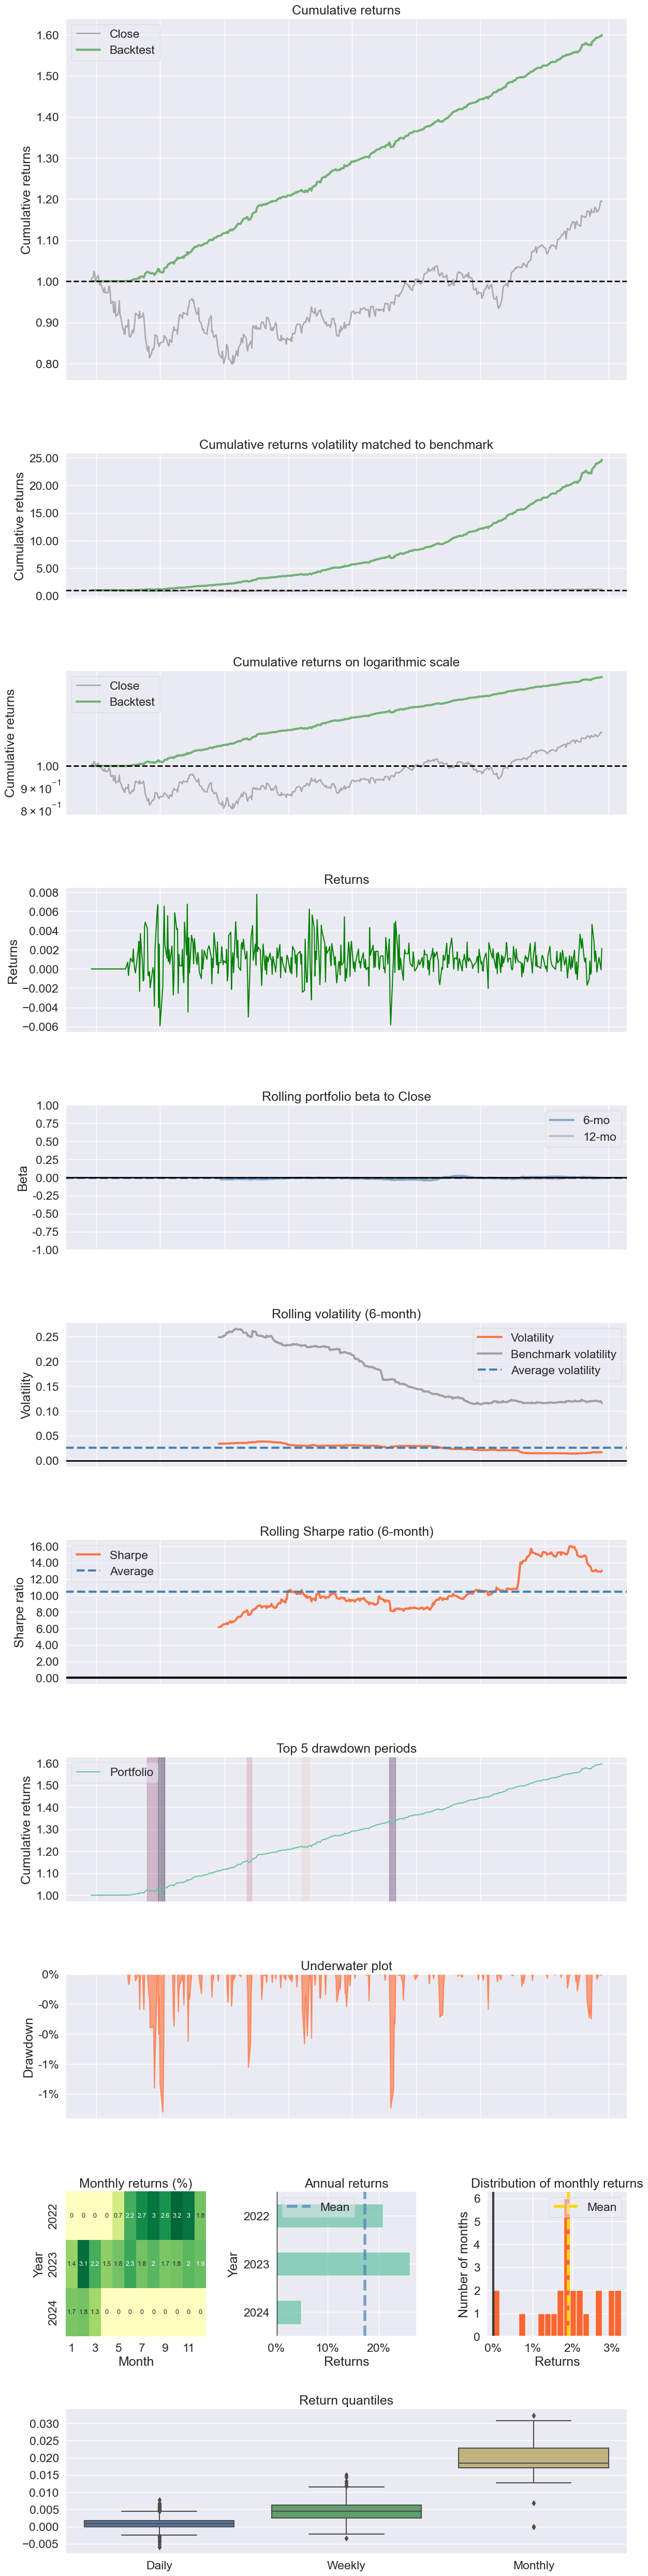

In [44]:
import pyfolio as pf
fig = pf.create_returns_tear_sheet(Pair_Rets.Pairs_Returns, benchmark_rets=bench, return_fig= True)
fig.savefig('porfolio_report/%s'%(end.strftime('%Y_%m_%d')))

In [45]:
Pair_Rets.mean().values[0]

0.0009372277472107105

C:\Users\IsaacPC\AppData\Local\Temp\ipykernel_23356\3939018212.py:6: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(Pair_Rets, hist = True, kde = True, bins=35,


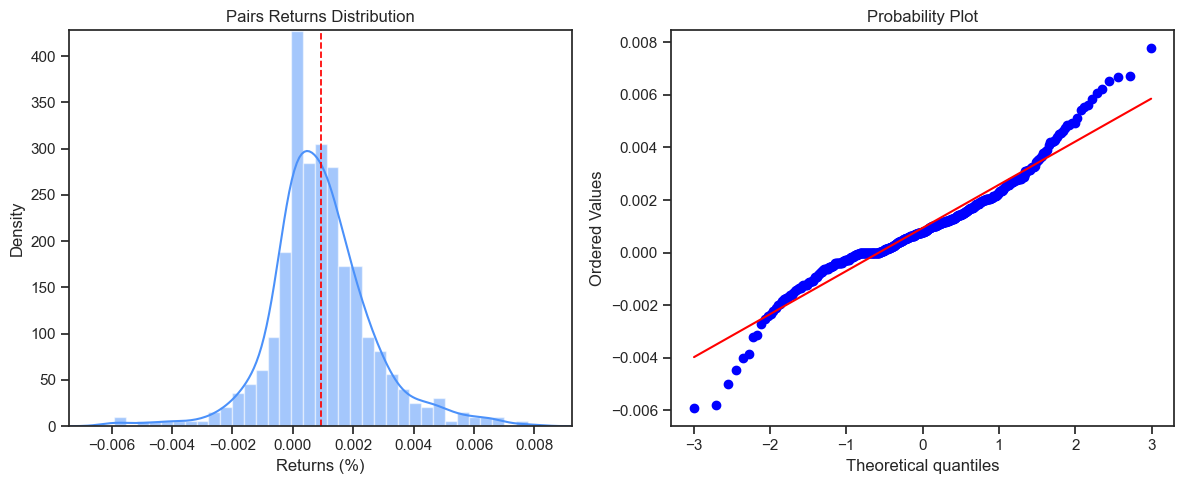

In [46]:
from scipy import stats


fig, (ax1, ax2) = plt.subplots(1,2,figsize=(12, 5))

sns.distplot(Pair_Rets, hist = True, kde = True, bins=35,
                 hist_kws = {'linewidth': 1, 'alpha':.5},
                 label='Pairs Returns', color='#4b91fa', ax=ax1)

ax1.axvline(x=Pair_Rets.mean().values[0], color='#ff0000', linewidth=1.25, linestyle='dashed',label = 'Returns Mean')

ax1.set_title('Pairs Returns Distribution')
ax1.margins(0.001)
ax1.set_xlabel('Returns (%)')
ax1.set_ylabel('Density')

stats.probplot(Pair_Rets.Pairs_Returns, plot=ax2)

plt.tight_layout()

plt.show()

array([<Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >], dtype=object)

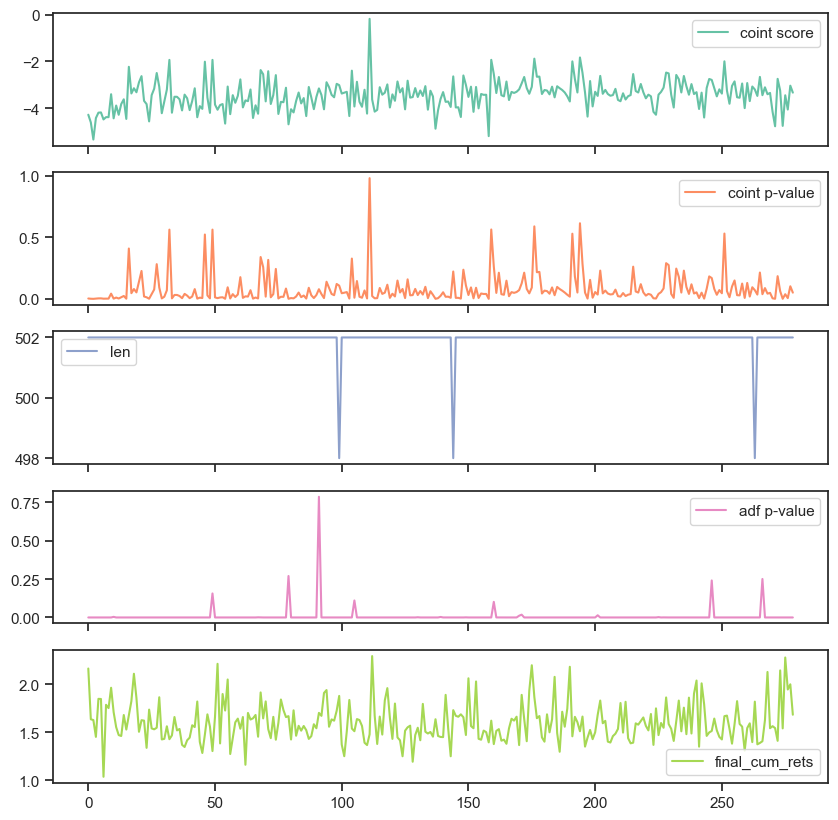

In [47]:
df_pair_score.plot(figsize=(10,10),subplots=True)

Check the distribution of len

C:\Users\IsaacPC\AppData\Local\Temp\ipykernel_23356\4095186782.py:3: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df_pair_score.len, hist = True, kde = True, bins=35,


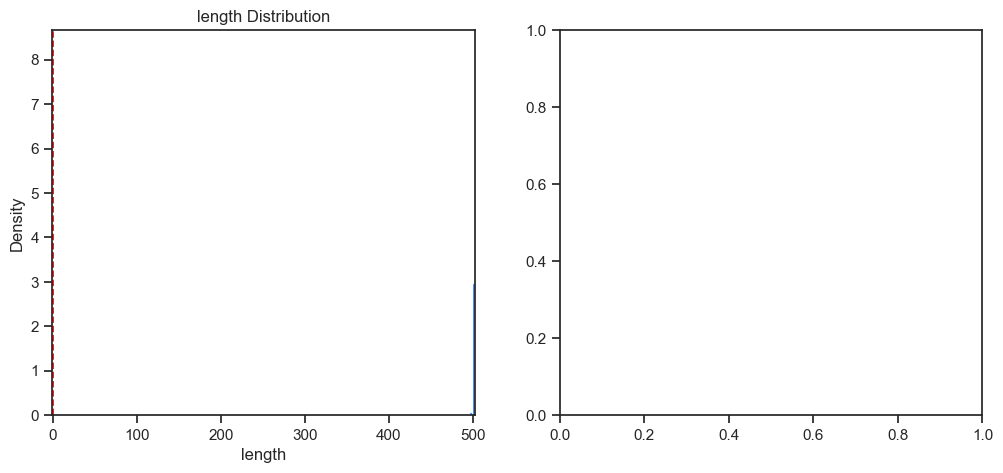

In [48]:
fig, (ax1, ax2) = plt.subplots(1,2,figsize=(12, 5))

sns.distplot(df_pair_score.len, hist = True, kde = True, bins=35,
                 hist_kws = {'linewidth': 1, 'alpha':.5},
                 label='Pairs Returns', color='#4b91fa', ax=ax1)

ax1.axvline(x=Pair_Rets.mean().values[0], color='#ff0000', linewidth=1.25, linestyle='dashed',label = 'Returns Mean')

ax1.set_title('length Distribution')
ax1.margins(0.001)
ax1.set_xlabel('length')
ax1.set_ylabel('Density')

plt.show()

Check correlation

In [49]:
corr = df_pair_score.corr()
corr.style.background_gradient(cmap='coolwarm')


h:\anaconda\envs\backtest\lib\site-packages\pandas\plotting\_matplotlib\core.py:1114: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  scatter = ax.scatter(


<Axes: xlabel='adf p-value', ylabel='final_cum_rets'>

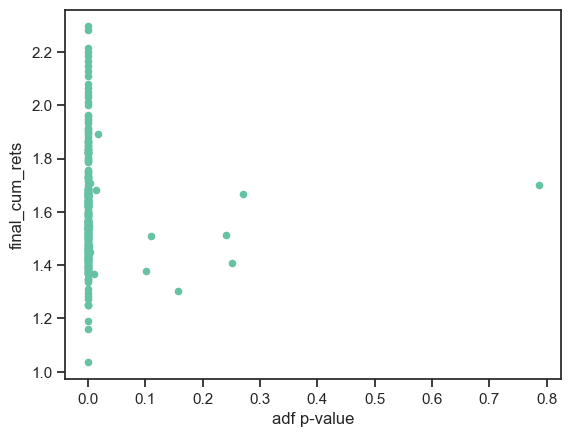

In [50]:
df_pair_score.plot.scatter(x='adf p-value', y='final_cum_rets')

In [51]:
df_pair_score.describe()

coint score  coint p-value         len   adf p-value  final_cum_rets
count   279.000000     279.000000  279.000000  2.790000e+02      279.000000
mean     -3.434685       0.080727  501.956989  7.097656e-03        1.601559
std       0.629572       0.123145    0.413286  5.516337e-02        0.205742
min      -5.334648       0.000038  498.000000  2.092081e-13        1.034770
25%      -3.819611       0.012761  502.000000  2.353324e-07        1.458665
50%      -3.419548       0.040225  502.000000  2.942626e-06        1.558598
75%      -3.102854       0.087732  502.000000  2.641228e-05        1.682813
max      -0.182309       0.980638  502.000000  7.863483e-01        2.296148

In [52]:
df_pair_score[df_pair_score['final_cum_rets']==1]

Empty DataFrame
Columns: [pairs, coint score, coint p-value, len, adf p-value, final_cum_rets, signal]
Index: []

In [53]:
df_pair_score['signal']

0      {nan, 1.0, 0.0, -1.0}
1      {nan, 0.0, 1.0, -1.0}
2      {nan, 0.0, -1.0, 1.0}
3      {nan, 0.0, -1.0, 1.0}
4      {nan, 0.0, -1.0, 1.0}
5      {nan, 0.0, -1.0, 1.0}
6      {nan, 0.0, 1.0, -1.0}
7      {nan, 0.0, -1.0, 1.0}
8      {nan, 0.0, -1.0, 1.0}
9      {nan, 0.0, -1.0, 1.0}
10     {nan, 0.0, -1.0, 1.0}
11     {nan, 1.0, 0.0, -1.0}
12     {nan, 1.0, 0.0, -1.0}
13     {nan, 0.0, 1.0, -1.0}
14     {nan, 0.0, 1.0, -1.0}
15     {nan, 0.0, 1.0, -1.0}
16     {nan, 0.0, -1.0, 1.0}
17     {nan, 0.0, -1.0, 1.0}
18     {nan, 1.0, 0.0, -1.0}
19     {nan, 0.0, -1.0, 1.0}
20     {nan, 0.0, -1.0, 1.0}
21     {nan, 0.0, -1.0, 1.0}
22     {nan, 0.0, -1.0, 1.0}
23     {nan, 0.0, -1.0, 1.0}
24     {nan, 0.0, 1.0, -1.0}
25     {nan, 1.0, 0.0, -1.0}
26     {nan, 0.0, 1.0, -1.0}
27     {nan, 0.0, -1.0, 1.0}
28     {nan, 0.0, 1.0, -1.0}
29     {nan, 0.0, -1.0, 1.0}
30     {nan, 0.0, -1.0, 1.0}
31     {nan, 0.0, -1.0, 1.0}
32     {nan, 1.0, 0.0, -1.0}
33     {nan, 0.0, 1.0, -1.0}
34     {nan, 0

h:\anaconda\envs\backtest\lib\site-packages\pandas\plotting\_matplotlib\core.py:1114: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  scatter = ax.scatter(


<Axes: xlabel='adf p100', ylabel='final_cum_rets'>

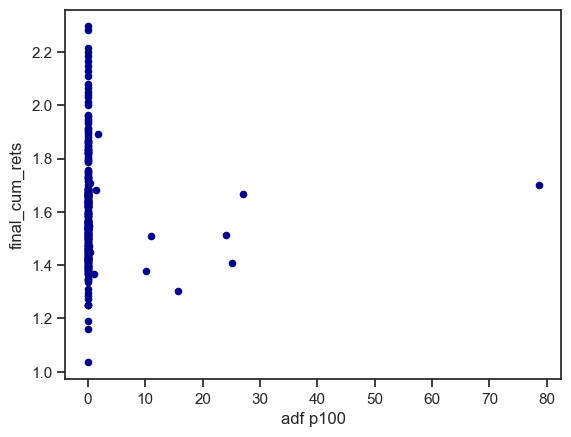

In [54]:
df_pair_score['adf p100'] = df_pair_score['adf p-value']*100
df_pair_score.plot.scatter(x='adf p100',
                      y='final_cum_rets',
                      c='DarkBlue')

In [55]:
df_pair_score['adf p-value']

0      2.600092e-09
1      3.410025e-08
2      5.034342e-10
3      2.411574e-07
4      5.868526e-09
5      5.600054e-09
6      2.092081e-13
7      4.949056e-06
8      8.791616e-08
9      1.908083e-08
10     3.837672e-03
11     2.941011e-08
12     1.012306e-07
13     2.854803e-08
14     5.884538e-07
15     6.133240e-10
16     5.256901e-08
17     3.836540e-05
18     4.016614e-04
19     3.646171e-05
20     5.648766e-07
21     1.133997e-04
22     1.678007e-07
23     1.143850e-07
24     1.018058e-07
25     6.317829e-08
26     9.674454e-05
27     1.194199e-07
28     4.261270e-06
29     1.330789e-07
30     3.683725e-04
31     7.083051e-09
32     1.305494e-05
33     7.125436e-09
34     4.997737e-06
35     1.894168e-05
36     5.486104e-06
37     1.451004e-07
38     3.712152e-05
39     2.619152e-07
40     3.779434e-06
41     6.000171e-09
42     1.683901e-05
43     4.853992e-07
44     5.028069e-05
45     9.142644e-06
46     8.885979e-05
47     2.892845e-05
48     7.478794e-07
49     1.564010e-01
